In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [20]:
rerun = True
filename_end = ""
folder_name = "files/"
subfolder_name = "spec_comp_3/"

In [31]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i], t2s[met_i - 1:met_i], M_0s[met_i - 1:met_i]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [32]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

In [36]:
snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 25.0, 37.50, 50.0, 62.50, 75.0, 87.50, 100.0])

L = 0.4
noise_threshold = 1e-30
L_ = int(L*sig.size)

n_avgs = 10

In [37]:
c_sigs = np.zeros((snrs.size, sig.size), dtype = np.complex128)
r_sigs = np.zeros((snrs.size, sig.size), dtype = np.complex128)

dists = np.zeros((n_avgs, snrs.size), dtype = float)
omegas_ = np.zeros((n_avgs, snrs.size), dtype = float)
s0s_ = np.zeros((n_avgs, snrs.size), dtype = float)
t2s_ = np.zeros((n_avgs, snrs.size), dtype = float)
phis_ = np.zeros((n_avgs, snrs.size), dtype = float)

# s0__ = np.array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}])
# phi__ = np.array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}])
# omega__ = np.array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}])
# t2s__ = np.array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}])

In [38]:
if rerun == True:
    for i in range(snrs.size):
        for j in range(n_avgs):

            c_sig_fft = awgn(sig_fft, snrs[i])
            c_sigs[i, :]  = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

            fil_sig, z, r = pymri.filter_sig(c_sigs[i, :], L, noise_threshold, return_full_arrays=True, return_poles_and_res=True)
            calc_s0s, calc_phis, calc_ws, calc_t2s = pymri.calculate_variables_from_z_and_r(z, r, dt)
            calc_t2s = 1/calc_t2s

            k = np.argmin( np.abs(pymri.chem_shift_from_f(pymri.rad_to_hz(calc_ws), B0) - 
                                    np.tile(pymri.chem_shift_from_f(pymri.rad_to_hz(ws), B0), L_)))
            
            dists[j, i] = np.abs(pymri.chem_shift_from_f(pymri.rad_to_hz(calc_ws), B0) - 
                                    np.tile(pymri.chem_shift_from_f(pymri.rad_to_hz(ws), B0), L_)) [k]
            
            s0s_[j, i] = np.abs(calc_s0s - np.tile(M_0s, L_))[k]   
            t2s_[j, i] = np.abs(calc_t2s - np.tile(t2s, L_))[k]   
            phis_[j, i] = np.abs(calc_phis - np.tile(spins_phi, L_))[k]

## File Saving

In [39]:
if rerun == True:
    file = open(folder_name + subfolder_name + "dists" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in dists[i, :]) + "\n")
    file.close()

    file = open(folder_name + subfolder_name + "dists_s0s" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in s0s_[i, :]) + "\n")
    file.close()

    file = open(folder_name + subfolder_name + "dists_t2s" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in t2s_[i, :]) + "\n")
    file.close()

    file = open(folder_name + subfolder_name + "dists_phis" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in phis_[i, :]) + "\n")
    file.close()

In [ ]:
# If simulation is lost
if rerun == False:
    file_in = pd.read_csv(folder_name + subfolder_name + "dists" + filename_end + ".csv")

    snrs = file_in.keys().to_numpy(dtype=np.float64)
    dists = file_in.values


## Statistics

In [40]:
avg_dists = np.average(dists, axis = 0)
std_dists = np.std(dists, axis = 0)

avg_s0s = np.average(s0s_, axis = 0)
std_s0s = np.std(s0s_, axis = 0)

avg_omegas = np.average(omegas_, axis = 0)
std_omegas = np.std(omegas_, axis = 0)

avg_t2s = np.average(t2s_, axis = 0)
std_t2s = np.std(t2s_, axis = 0)

avg_phis = np.average(phis_, axis = 0)
std_phis = np.std(phis_, axis = 0)

Text(0.5, 1.0, '$\\phi$')

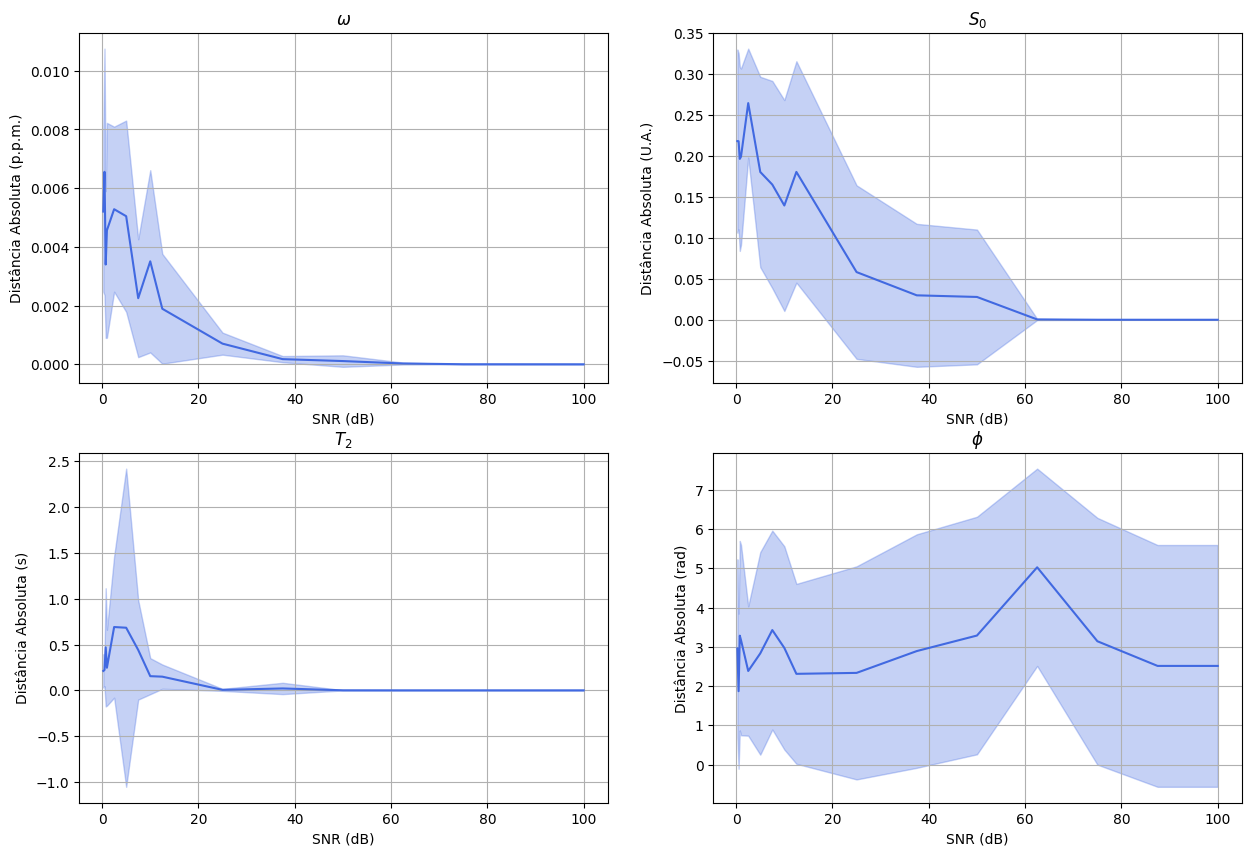

In [48]:
plt.figure(figsize = (15, 10))

plt.subplot(221)
plt.plot(snrs, avg_dists, c = "royalblue")
plt.fill_between(snrs, avg_dists - std_dists, avg_dists + std_dists, alpha = 0.3, color = "royalblue", label = "Desvio Padrão")
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("Distância Absoluta (p.p.m.)")
plt.title(r"$\omega$")

plt.subplot(222)
plt.plot(snrs, avg_s0s, c = "royalblue")
plt.fill_between(snrs, avg_s0s - std_s0s, avg_s0s + std_s0s, alpha = 0.3, color = "royalblue", label = "Desvio Padrão")
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("Distância Absoluta (U.A.)")
plt.title(r"$S_0$")

plt.subplot(223)
plt.plot(snrs, avg_t2s, c = "royalblue")
plt.fill_between(snrs, avg_t2s - std_t2s, avg_t2s + std_t2s, alpha = 0.3, color = "royalblue", label = "Desvio Padrão")
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("Distância Absoluta (s)")
plt.title(r"$T_2$")

plt.subplot(224)
plt.plot(snrs, avg_phis, c = "royalblue")
plt.fill_between(snrs, avg_phis - std_phis, avg_phis + std_phis, alpha = 0.3, color = "royalblue", label = "Desvio Padrão")
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("Distância Absoluta (rad)")
plt.title(r"$\phi$")